# Simulating 2D VEP model

In [1]:
import os
import sys
import time
import errno
import time


import numpy as np
import scipy as scp
import scipy as scp
import matplotlib.pyplot as plt

import re
import pandas as pd
import seaborn as sns


In [2]:
from scipy.optimize import fsolve
from scipy.optimize import root
from scipy import stats as spstats

In [3]:
import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
import sbi.utils as utils
from sbi.inference.base import infer

In [4]:
from tvb.simulator.lab import *

/home/meysam/anaconda3/lib/python3.6/site-packages/tvb_library-2.0-py3.6.egg/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'y1': array([-20.,   2.]), 'z': array([2., 5.]), 'x2': array([-2.,  0.]), 'y2': array([0., 2.]), 'g': array([-1.,  1.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.epileptor.Epileptor2D.tt = NArray(label='tt', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor2D.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'z': array([2., 5.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.epileptor

WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetFitzHughNagumo.state_variable_range = Final(field_type=<class 'dict'>, default={'xi': array([-4.,  4.]), 'eta': array([-3.,  3.]), 'alpha': array([-4.,  4.]), 'beta': array([-3.,  3.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.a = NArray(label=':math:`a`', dtype=float64, default=array([1.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 3.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.b = NArray(label=':math:`b`', dtype=float64, default=array([3.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindma

In [5]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [6]:
# plt.style.use('seaborn-talk');

# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'Helvetica'
# plt.rcParams['axes.edgecolor']='#333F4B'
# plt.rcParams['axes.linewidth']=0.8
# plt.rcParams['xtick.color']='#333F4B'
# plt.rcParams['ytick.color']='#333F4B'

In [7]:
cwd = os.getcwd()
cwd

'/data/SBI'

# Patient CJ

In [8]:
cwd = os.getcwd()
cwd

'/data/SBI'

## Structural Connectivity Matrix

In [9]:
con = connectivity.Connectivity.from_file(os.path.join(cwd+"/ExperimentalData_CJ", "connectivity.zip"))
#con.speed = np.inf

# normalize
con.weights = con.weights/np.max(con.weights)
num_regions = len(con.region_labels)

WARNING  File 'hemispheres' not found in ZIP.


In [10]:
con.weights[0,0], con.weights[1,1], con.weights[1,2]

(0.016833422732099264, 0.006551652417598056, 0.0005664962616720124)

In [11]:
con.weights.min(), con.weights.max()

(0.0, 1.0)

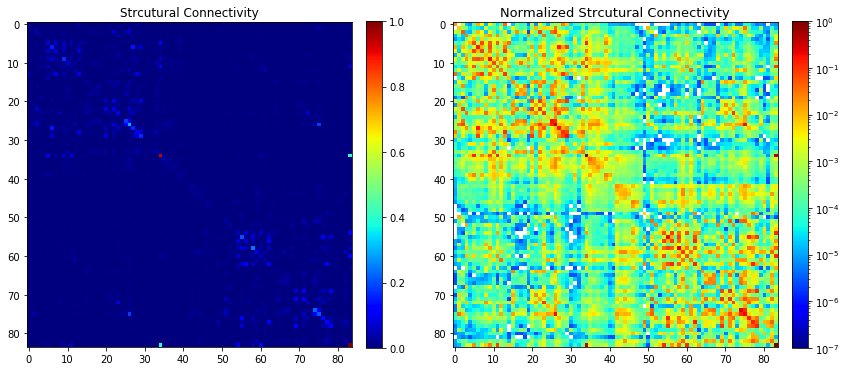

In [12]:
from matplotlib import colors, cm

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow((con.weights), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Strcutural Connectivity')

plt.subplot(122)
norm = colors.LogNorm(1e-7, con.weights.max())
im = plt.imshow(con.weights,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Normalized Strcutural Connectivity', fontsize=13.0)
plt.savefig(os.path.join(cwd+'/Figs',"Connectivity_CJ.png"))
plt.show()

## ROIs chosen as Epileptogenic/propagation zones

In [13]:
iz_val=-3.65
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

### scaled down the coupling from all nodes to EZ to avoid inhibition due to strong coupling


In [14]:
con.weights[np.ix_(pz_kplng_idx, ez_idx)] = 4.0
con.weights[np.ix_(pz_wplng_idx, ez_idx)] = 1.0

con.weights[np.diag_indices(con.weights.shape[0])] = 0

con.cortical[:] = True     # To avoid adding analytical gain matrix for subcortical sources

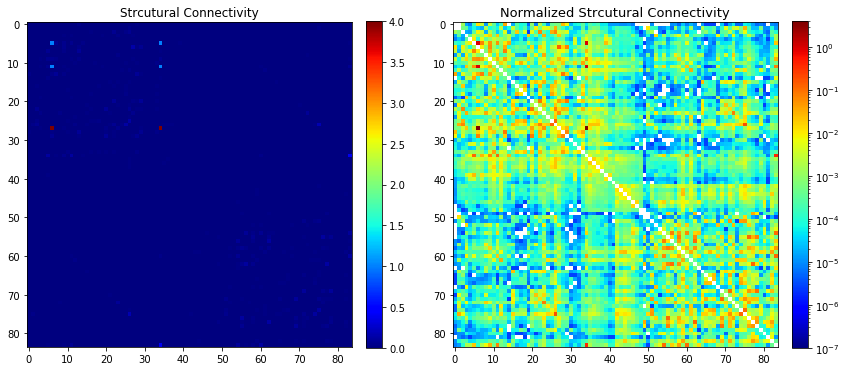

In [15]:
from matplotlib import colors, cm

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow((con.weights), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Strcutural Connectivity')

plt.subplot(122)
norm = colors.LogNorm(1e-7, con.weights.max())
im = plt.imshow(con.weights,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Normalized Strcutural Connectivity', fontsize=13.0)
plt.savefig(os.path.join(cwd+'/Figs',"Modified Connectivity_CJ_config2.png"))
plt.show()

In [16]:
con.weights[27,6], con.weights[6,27], con.weights[27,34], con.weights[6,34]

(4.0, 0.14511882738010531, 4.0, 0.0007005944105702181)

In [17]:
con.weights[5,11], con.weights[5,6], con.weights[5,34], con.weights[34, 5]

(0.053932086129325346, 1.0, 1.0, 0.11952797451587832)

In [18]:
con.weights.min(), con.weights.max()

(0.0, 4.0)

In [19]:
SC=con.weights
SC.shape

(84, 84)

### Features

In [20]:
T = 15.0
dt=0.1
ts = np.arange(0, T + dt, dt)
sigma=1e-1

In [21]:
nt=ts.shape[0]
nt

151

In [22]:
tau0=10.
I1=3.1
eta_true=-1.5

In [23]:
x, z= np.zeros(nt), np.zeros(nt)

In [24]:
x_init, z_init=-2.5, 3.5
x[0],z[0]=x_init, z_init

In [25]:
for i in range(1, nt):
    dx =1.0 - x[i-1]**3 - 2.0*x[i-1]**2 - z[i-1] + I1   
    dz =(1.0/tau0)*(4*(x[i-1]-eta_true) - z[i-1])
    x[i]=(x[i-1] + dt * dx )
    z[i]=(z[i-1] + dt * dz)    

In [26]:
ts.shape, x.shape

((151,), (151,))

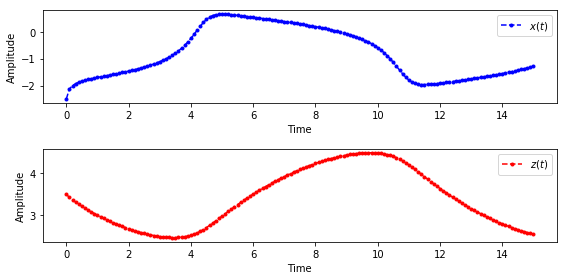

In [27]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.plot(ts,x , '--b.', label='$x(t)$')
plt.xlabel('Time'); plt.ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout();
plt.subplot(212)
plt.plot(ts, z, '--r.', label='$z(t)$')
plt.xlabel('Time'); ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout();
plt.show()

In [28]:
def nullclines(X,Y, eta):   
    dX =  1.0 - X**3 - 2.0*X**2 - Y + I1 
    dY =  4*(X-eta) - Y
    contour(X, Y, dX, 0, colors='r')
    contour(X, Y, dY, 0, colors='g') 

In [29]:
def root_fuc(roots, eta):   
    xx = empty(1)
    zz = empty(1)
    F = empty(2)
    xx = roots[0]
    zz = roots[1]
    F[0] =1.0 - xx**3 - 2.0*xx**2 - zz + I1 
    F[1] =4*(xx-eta) - zz
    return np.array([F[0], F[1]])

In [30]:
rGuess=array([[-1.,3.]])
true_roots = fsolve(root_fuc,rGuess, args=(eta_true,))

print('true_roots:', true_roots)

true_roots: [-0.6014927   3.59402919]


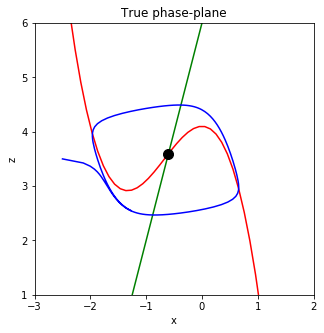

In [31]:
X, Z = mgrid[-5.0:5.0:100j, 0.0:10.0:100j]

plt.figure(figsize=(5, 5))
plt.plot(x, z, 'b')
nullclines(X,Z,  eta_true)
plt.plot(true_roots[0], true_roots[1] , marker="o", markersize=10, color='k')
plt.xlabel('x'); plt.ylabel('z'); 
plt.title('True phase-plane')
plt.xlim((-3,2)), plt.ylim((1,6))
plt.show()

In [32]:
x.shape, ts.shape

((151,), (151,))

In [33]:
def func_2DepileptorEqs(y, eta, K, I, SC):  
    num_nodes= int(SC.shape[0])
    x = np.empty(num_nodes)
    z = np.empty(num_nodes)
    F = np.empty(2*num_nodes)
    for i in np.r_[0:num_nodes]:
        x[i] = y[2*i]
        z[i] = y[2*i+1]
    for i in np.r_[0:num_nodes]: 
        gx=0
        for j in np.r_[0:num_nodes]:
               gx=gx+SC[i,j]*(x[j]-x[i])  
        F[2*i] = -x[i]**3-2*x[i]**2-z[i]+I
        F[2*i+1] = 4*(x[i]-eta[i])-z[i]-K*gx   
    return F 

In [34]:
I=I1+1;

In [35]:
InitialGuess=np.array([[-1.0, 3.0]])

In [36]:
rGuess = np.repeat(InitialGuess, int(SC.shape[0]), axis=0)
rGuess.shape

(84, 2)

In [37]:
#true_roots_K0 = fsolve(func_2DepileptorEqs,rGuess, args=(eta_true, 0.0, I, SC))
#true_roots = fsolve(func_2DepileptorEqs,rGuess, args=(eta_true_mu, Ks, I, SC))

In [38]:
# seizures_num=[]
# seizures_on=[]
# seizures_off=[]


# v=np.zeros(nt)
# v= np.array(x)



# v_th=-2
# ind = np.where(v < v_th)
# v[ind] = v_th

# ind_on = np.where((np.diff(v) > 0))
# seizures_times_onset = np.arange(0, ts.shape[0], dt)[ind_on]

# ind_off = np.where((np.diff(v) < 0))
# seizures_times_offset = np.arange(0, ts.shape[0], dt)[ind_off]


# if seizures_times_onset.shape[0] > 0:
#             seizures_times_onset = seizures_times_onset[np.append(1, np.diff(seizures_times_onset)) > .5]
#             seizures_on.append(seizures_times_onset[0])
            
#             seizures_times_offset = seizures_times_offset[np.append(1, np.diff(seizures_times_offset)) > .5]
#             seizures_off.append(seizures_times_offset[0])

# else:            
#             seizures_on.append(np.inf)
#             seizures_off.append(np.inf)

    
# seizures_num.append(seizures_times_onset.shape[0])  
          

            

   

In [39]:
seizures_num=[]
seizures_on=[]

v=np.zeros(nt)
v= np.array(x)



v_th=-1
ind = np.where(v < v_th)
v[ind] = v_th


ind = np.where(np.diff(v) < 0)

spike_times = np.arange(0, ts.shape[0], dt)[ind]
#spike_times = np.array(ts)[ind]
spike_times_stim = spike_times

if spike_times_stim.shape[0] > 0:
            spike_times_stim = spike_times_stim[np.append(1, np.diff(spike_times_stim)) > .5]
            seizures_on.append(spike_times_stim[0])
else:            
            seizures_on.append(np.inf)

seizures_num.append(spike_times_stim.shape[0])  

   

In [40]:
seizures_num, seizures_on

([1], [5.0])

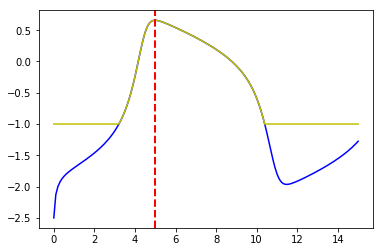

In [41]:
plt.plot(ts,x, 'b');
plt.plot(ts,v, 'y');
for i in np.r_[0:len(seizures_num)]:
     plt.axvline(x=seizures_on[i], linewidth=2, color = 'r', linestyle='--')
     #plt.axvline(x=seizures_times_offset[i], linewidth=2, color = 'g', linestyle='--')

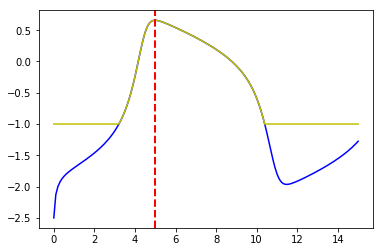

In [42]:
plt.plot(ts,x, 'b');
plt.plot(ts,v, 'y');
for i in np.r_[0:len(seizures_num)]:
     plt.axvline(x=seizures_on[i], linewidth=2, color = 'r', linestyle='--')
     #plt.axvline(x=seizures_times_offset[i], linewidth=2, color = 'g', linestyle='--')

### constants

In [43]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0
eta_hi=1.0
eta_lo=-5.0                  
prior_std =1.0
sd_thr=0.8

### Simulator

In [44]:
def VEP2D_ODEmodel(eta, constants, x_init, z_init, SC, K, dt, ts, seed=None):
   

    # fixed parameters
    tau0, I1=constants[0], constants[1]
    
    tstep = float(dt)

    if seed is not None:
        rng = np.random.RandomState(seed=seed)
    else:
        rng = np.random.RandomState()
    
    nt=ts.shape[0]
    nn=SC.shape[0]
        
    # simulation from initial point
    x = np.zeros((nn, nt))  # fast voltage
    z = np.zeros((nn, nt))  # slow voltage

    
    for i in range(0, nn):
          x[i, 0] = x_init
          z[i, 0] = z_init
    
    
    for t in range(0, nt-1):
        for i in range(0, nn):
            gx = 0;
            for j in range(0, nn):
                    gx = gx + SC[i, j]*(x[j, t] - x[i, t]);
            dx = 1.0 - x[i, t]*x[i, t]*x[i, t] - 2.0*x[i, t]*x[i, t] - z[i, t] + I1;
            dz = (1/tau0)*(4*(x[i, t] - eta[i]) - z[i, t] - K*gx);
            x[i, t+1] = x[i, t] + dt*dx 
            z[i, t+1] = z[i, t] + dt*dz 
  
        
    return np.array(x).reshape(-1)  
     

In [45]:
def calculate_summary_statistics(x, params, dt, ts):
    """Calculate summary statistics

    Parameters
    ----------
    x : output of the simulator

    Returns
    -------
    np.array, summary statistics
    """
    
    params = np.asarray(params)

    nt=ts.shape[0]
    nn=params.shape[0]-1
    
    eta=params[0:nn]
    K=params[-1]
    
    
    X=x.reshape(nn, nt)

    n_summary = 6*nn

    seizures_num=[]
    seizures_on=[]
    seizures_mean=[]
    seizures_std=[]

    for i in np.r_[0:nn]:
                v=np.zeros(nt)
                v= np.array(X[i,:])

                seizures_mean.append(np.mean(v))
                seizures_std.append(np.std(v))

                v_th=-1
                ind = np.where(v < v_th)
                v[ind] = v_th


                ind = np.where(np.diff(v) < 0)

                spike_times = np.arange(0, ts.shape[0], dt)[ind]
                #spike_times = np.array(ts)[ind]
                spike_times_stim = spike_times

                if spike_times_stim.shape[0] > 0:
                            spike_times_stim = spike_times_stim[np.append(1, np.diff(spike_times_stim)) > .5]
                            seizures_on.append(spike_times_stim[0])
                else:            
                            seizures_on.append(100000.)

                seizures_num.append(spike_times_stim.shape[0])  


    #rGuess = np.repeat(InitialGuess, nn, axis=0)

    #true_roots_K = fsolve(func_2DepileptorEqs,rGuess, args=(eta, K, I, SC))


    sum_stats_vec = np.concatenate((np.array(seizures_mean), np.array(seizures_std), 
                                    np.array(seizures_num), np.array(seizures_on),
                                    ))

    sum_stats_vec = sum_stats_vec[0:n_summary]        


    return sum_stats_vec


In [46]:
def VEP2D_simulator(params):

    params = np.asarray(params)
    
    # input, time step
    constants = np.array([10.0, 3.1])
    T = 15.0
    dt=0.1
    ts = np.arange(0, T + dt, dt)

    nt=ts.shape[0]
    nn=params.shape[0]-1
    
    eta=params[0:nn]
    K=params[-1]
    
    x_init=-2.5
    z_init=3.5
    
    states = VEP2D_ODEmodel(eta, constants, x_init, z_init, SC, K, dt, ts, seed=0)

    return states.reshape(-1)  

In [47]:
def VEP2D_simulator_wrapper(params):

    params = np.asarray(params)
    
    # input, time step
    constants = np.array([10.0, 3.1, 1e-1])
    T = 15.0
    dt=0.1
    ts = np.arange(0, T + dt, dt)

    nt=ts.shape[0]
    nn=params.shape[0]-1
    
    eta=params[0:nn]
    K=params[-1]
    
    x_init=-2.5
    z_init=3.5
    
    states = VEP2D_ODEmodel(eta, constants, x_init, z_init, SC, K, dt, ts, seed=0)

    summstats = torch.as_tensor(calculate_summary_statistics(states, params, dt, ts))

    return summstats 

### some simulations

In [48]:
T = 15.0
dt=0.1
ts = np.arange(0, T + dt, dt)
sigma=1e-1

In [49]:
ts.shape

(151,)

In [50]:
nn=SC.shape[0]
nn

84

In [51]:
eta_true = np.ones(nn)*iz_val
eta_true[ez_idx] = ez_val
eta_true[pz_idx] = pz_val

In [52]:
K_true=1.

In [53]:
x_init=-2.5
z_init=3.5

In [54]:
params_true = np.append(eta_true, K_true)
params_true.shape

(85,)

In [55]:
params_true

array([-3.65, -3.65, -3.65, -3.65, -3.65, -2.4 , -1.6 , -3.65, -3.65,
       -3.65, -3.65, -2.4 , -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
       -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
       -2.4 , -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -1.6 , -3.65,
       -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
       -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
       -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
       -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
       -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65, -3.65,
       -3.65, -3.65, -3.65,  1.  ])

In [56]:
start_time = time.time()
Sim =VEP2D_simulator(params=params_true)
print(" single sim (sec) takes:" , (time.time() - start_time))

 single sim (sec) takes: 1.6336817741394043


In [57]:
Sim.shape

(12684,)

In [58]:
X=Sim.reshape(nn, int(Sim.shape[0]/nn))
X.shape

(84, 151)

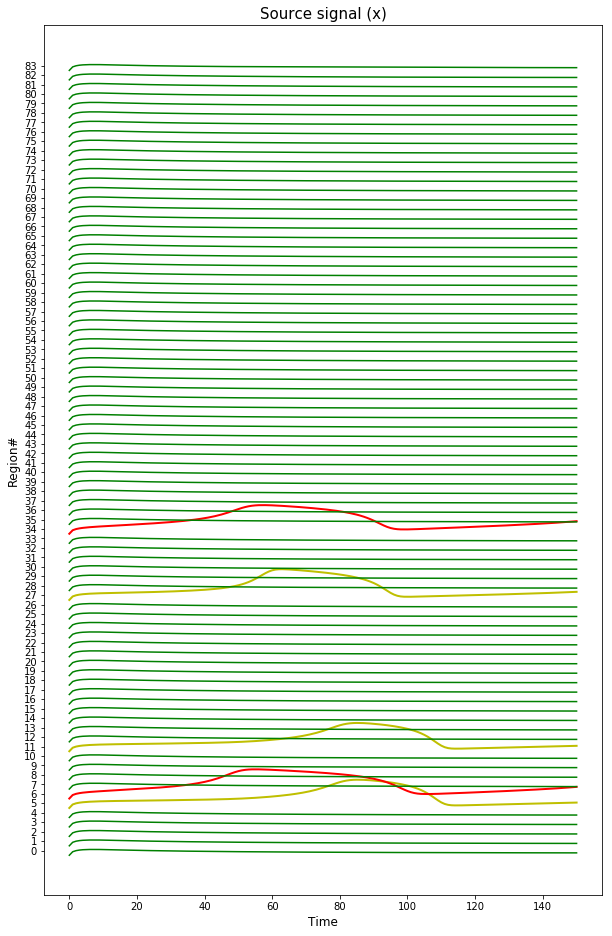

In [59]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(X[i,:]+i, 'r', lw=2)
    elif i in pz_idx:
          plt.plot(X[i,:]+i, 'y', lw=2)
    else:  
          plt.plot(X[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.title("Source signal (x)",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Region#',fontsize=12)
#plt.savefig(os.path.join(cwd+'/Figs',"SL_CJ_config2.png"))
plt.show()

In [60]:
X.shape, calculate_summary_statistics(X.reshape(-1), params_true, dt, ts).shape

((84, 151), (336,))

## 3. Prior over model parameters

In [61]:
nn+1

85

In [62]:
prior_min_eta=-5*np.ones(nn)
prior_min_K=0*np.ones(1)

prior_max_eta=-1*np.ones(nn)
prior_max_K=2*np.ones(1)

In [63]:
prior_min=np.append(prior_min_eta, prior_min_K)
prior_max=np.append(prior_max_eta, prior_max_K)

In [64]:
prior_min.shape, prior_max.shape

((85,), (85,))

In [65]:
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

### Inference

In [66]:
start_time = time.time()

posterior = infer(VEP2D_simulator_wrapper, prior, method='SNPE',  num_simulations=5000, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

A Jupyter Widget


Neural network successfully converged after 731 epochs.
------------------------------------------------------------
--- 36392.09398674965 seconds ---


### Data

In [67]:
obs=VEP2D_simulator(params=params_true)
obs_summary_statistics=calculate_summary_statistics(obs, params_true, dt, ts)

In [68]:
obs.shape, obs_summary_statistics.shape

((12684,), (336,))

In [69]:
y_obs=obs.reshape(nn, int(obs.shape[0]/nn))
y_obs.shape

(84, 151)

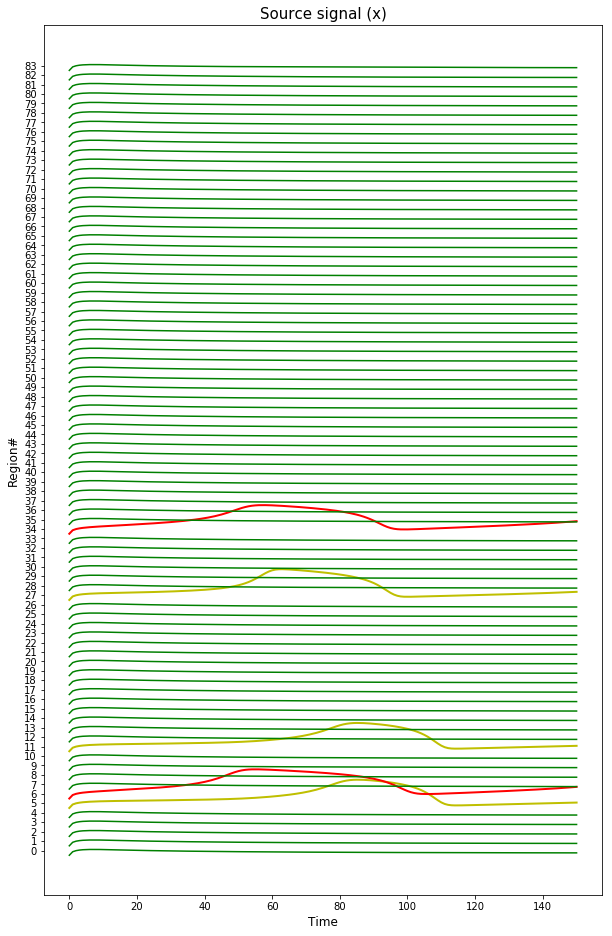

In [70]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(y_obs[i,:]+i, 'r', lw=2)
    elif i in pz_idx:
          plt.plot(y_obs[i,:]+i, 'y', lw=2)
    else:  
          plt.plot(y_obs[i,:]+i, 'g')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.title("Source signal (x)",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Region#',fontsize=12)
plt.savefig(os.path.join(cwd+"/Figs","SBI_BVEPobs_K1"+".png"), doi=800)
plt.savefig(os.path.join(cwd+"/Figs","SBI_BVEPobs_K1"+".eps"), doi=800)

### Posterior

In [71]:
num_samples=200

In [72]:
posterior_sample = posterior.sample((num_samples,), obs_summary_statistics, sample_with_mcmc=True,).numpy()

Generating samples: 100%|██████████| 200/200 [59:16<00:00, 17.78s/it]


In [73]:
posterior_sample.shape, params_true.shape

((200, 85), (85,))

In [74]:
# fig, axes = utils.pairplot(posterior_sample,
#                            fig_size=(8,8),
#                            points=eta_true,
#                            points_offdiag={'markersize': 20},
#                            points_colors='r');
# plt.savefig(os.path.join(cwd+"/Figs","SBI_ExcitabilityPaitplot_K1"+".png"), doi=800)
# plt.savefig(os.path.join(cwd+"/Figs","SBI_ExcitabilityPaitplot_K1"+".eps"), doi=800)

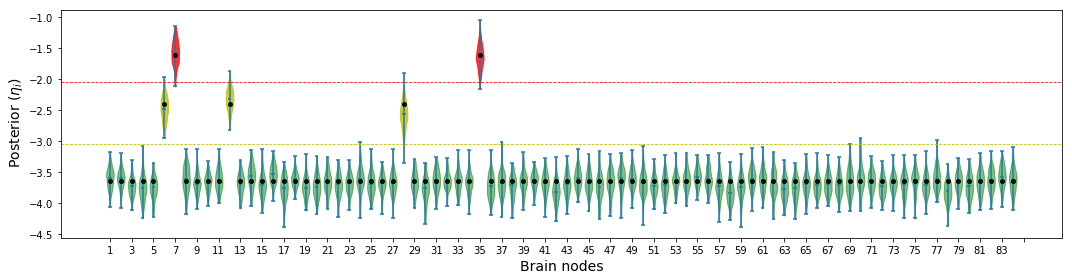

In [75]:
plt.figure(figsize=(15,4))
parts= plt.violinplot(posterior_sample[:,:-1], widths=0.7, showmeans=True, showextrema=True);
plt.plot(np.r_[0:nn]+1,params_true[:-1] ,'o', color='k', alpha=0.9, markersize=4)
plt.axhline(y=eta_c, linewidth=.8, color = 'r', linestyle='--')
plt.axhline(y=eta_c-delta_eta, linewidth=.8, color = 'y', linestyle='--')

plt.xticks(np.r_[1:nn+1], np.r_[1:nn+1], rotation=90, fontsize=8)  
plt.xticks(np.arange(1,nn+2, step=2),np.arange(1, nn+1, step=2), fontsize=10, rotation=0)
plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=14);  
plt.xlabel('Brain nodes', fontsize=14); 

for pc in parts['bodies'][0:nn]:
    pc.set_facecolor('g')
    pc.set_edgecolor('g')
    pc.set_alpha(0.5)
i = 0
while i < len(ez_idx):
    for pc in parts['bodies'][ez_idx[i]:ez_idx[i]+1]:
        pc.set_facecolor('r')
        pc.set_edgecolor('r')
        pc.set_alpha(0.8)
    i += 1

j = 0
while j < len(pz_idx):
    for pc in parts['bodies'][pz_idx[j]:pz_idx[j]+1]:
        pc.set_facecolor('y')
        pc.set_edgecolor('y')
        pc.set_alpha(0.8)
    j += 1
plt.tight_layout()
plt.savefig(os.path.join(cwd+"/Figs","SBI_InferredExcitability_K1"+".png"), doi=800)
plt.savefig(os.path.join(cwd+"/Figs","SBI_InferredExcitability_K1"+".eps"), doi=800)
plt.show()

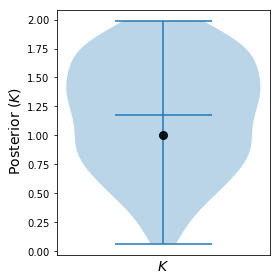

In [76]:
plt.figure(figsize=(4,4))
parts= plt.violinplot(posterior_sample[:,-1], widths=0.7, showmeans=True, showextrema=True);
plt.plot(1,params_true[-1] ,'o', color='k', alpha=0.9, markersize=8)
plt.ylabel(' Posterior ' +r'${(K)}$', fontsize=14);  
plt.xlabel(r'${K}$', fontsize=14); 
plt.xticks([])
plt.tight_layout()
plt.savefig(os.path.join(cwd+"/Figs","SBI_InferredCoupling_K1"+".png"), doi=800)
plt.savefig(os.path.join(cwd+"/Figs","SBI_InferredCoupling_K1"+".eps"), doi=800)
plt.show()

In [77]:
y_fit = VEP2D_simulator(np.percentile(posterior_sample, [50], axis=0).reshape(-1)).reshape(nn, int(obs.shape[0]/nn))
#y_ppc_lo = VEP2D_simulator(np.percentile(posterior_sample, [5], axis=0).reshape(-1)).reshape(nn, int(obs.shape[0]/nn))
#y_ppc_hi = VEP2D_simulator(np.percentile(posterior_sample, [95], axis=0).reshape(-1)).reshape(nn, int(obs.shape[0]/nn))

In [78]:
y_fit.shape

(84, 151)

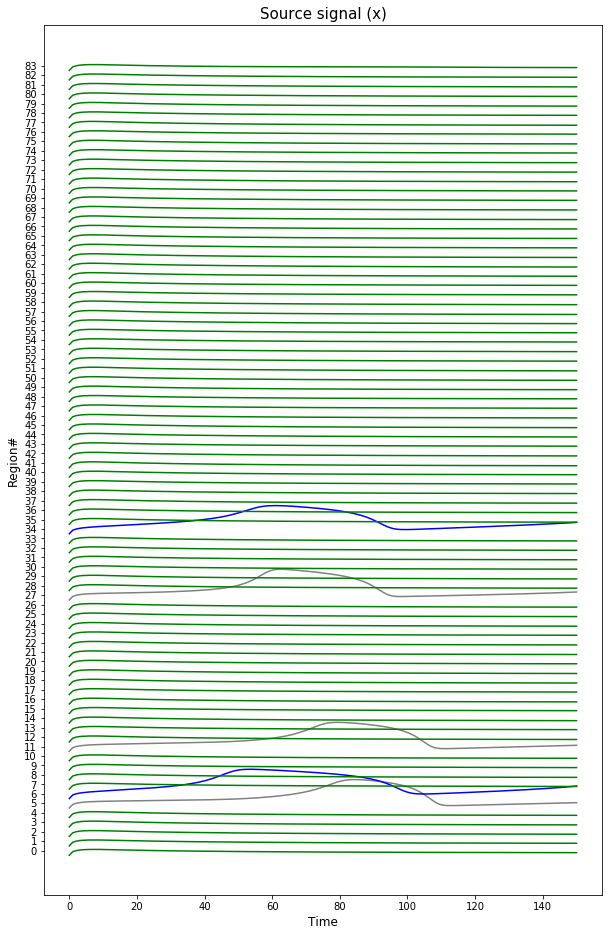

In [79]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          #plt.plot(y_obs[i,:]+i, '-o', color='r', linewidth=.5, alpha=0.7)
          plt.plot(y_fit[i,:]+i, color='b' )
    elif i in pz_idx:
          #plt.plot(y_obs[i,:]+i, '-o', color='y', linewidth=.5, alpha=0.7)
          plt.plot(y_fit[i,:]+i, color='grey')
    else:  
          #plt.plot(y_obs[i,:]+i, 'g')
          plt.plot(y_fit[i,:]+i, color='green')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.title("Source signal (x)",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Region#',fontsize=12)
plt.savefig(os.path.join(cwd+"/Figs","SBI_FittedBVEPobs_K1"+".png"), doi=800)
plt.savefig(os.path.join(cwd+"/Figs","SBI_FittedBVEPobs_K1"+".eps"), doi=800)

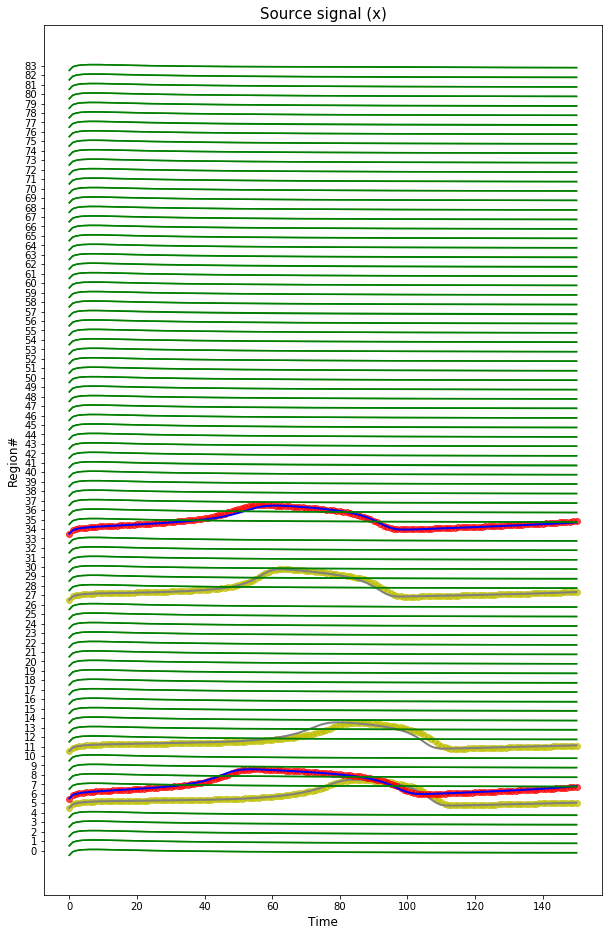

In [80]:
plt.figure(figsize=(10,16))
for i in range(0, nn):
    if i in ez_idx:
          plt.plot(y_obs[i,:]+i, '-o', color='r', linewidth=.5, alpha=0.7)
          plt.plot(y_fit[i,:]+i, color='b', lw=2 )
    elif i in pz_idx:
          plt.plot(y_obs[i,:]+i, '-o', color='y', linewidth=.5, alpha=0.7)
          plt.plot(y_fit[i,:]+i, color='grey', lw=2)
    else:  
          plt.plot(y_obs[i,:]+i, 'g')
          plt.plot(y_fit[i,:]+i, color='green')
plt.yticks(np.r_[0:nn]-2, np.r_[0:nn],fontsize=10)
plt.title("Source signal (x)",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Region#',fontsize=12)
plt.savefig(os.path.join(cwd+"/Figs","SBI_FittedBVEPobservation_K1"+".png"), doi=800)
plt.savefig(os.path.join(cwd+"/Figs","SBI_FittedBVEPobservation_K1"+".eps"), doi=800)
